In [5]:
# Parameters
artificial_humans = "../../artifacts/artificial_humans/03_dataset/model/dataset_all.pt"
artificial_humans_valid = "../../artifacts/artificial_humans/02_2_valid/model/rnn_True.pt"
artificial_humans_model = "graph"
manager = "../../artifacts/human_like_manager/04_features/model/prev_punishments_True__prev_manager_valid_True__round_n_False.pt"
output_path = "../../data/manager/simulate_rule/v1_comp/"
n_episode_steps = 16
n_episodes = 1000


In [6]:
%load_ext autoreload
%autoreload 2

import os
import torch as th
import numpy as np
import seaborn as sns
import pandas as pd
from itertools import count
from aimanager.utils.utils import make_dir

from aimanager.manager.memory import Memory
from aimanager.manager.environment_v3 import ArtificialHumanEnv
from aimanager.manager.manager import ArtificalManager
from aimanager.artificial_humans import GraphNetwork
from aimanager.utils.array_to_df import using_multiindex, add_labels

output_path = os.path.join(output_path, 'data')

plot_folder = f'plots/simulate_ah_hm'

make_dir(plot_folder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def mem_to_df(recorder, name):
    columns = ['round_number','participant_code']

    punishments = using_multiindex(recorder.memory['punishments'][0].numpy(), columns=columns, value_name='punishment')
    common_good = using_multiindex(recorder.memory['common_good'][0].numpy(), columns=columns, value_name='common_good')
    contributions = using_multiindex(recorder.memory['contributions'][0].numpy(), columns=columns, value_name='contribution')

    df_sim = punishments.merge(common_good).merge(contributions)

    df_sim['data_source'] = name
    return df_sim

In [8]:
device = th.device('cpu')
rec_device = th.device('cpu')
artifical_humans = GraphNetwork.load(artificial_humans, device=device)
artifical_humans_valid = GraphNetwork.load(artificial_humans_valid, device=device)

mg = GraphNetwork.load(manager, device=device)

n_agents_set = [2,3,4,8]

# run_settings = [
#     (n_agents, ah)
#     for n_agents in n_agents_set
#     for ah in artifical_humans.keys()
# ]

dfs = []
for e, n_agents in enumerate(n_agents_set):
    env = ArtificialHumanEnv(
        artifical_humans=artifical_humans, 
        artifical_humans_valid=artifical_humans_valid,
        n_agents=n_agents, n_contributions=21, n_punishments=31, 
        n_rounds=n_episode_steps, batch_size=n_episodes, device=device)
    recorder = Memory(n_episodes=1, n_episode_steps=n_episode_steps, output_file=None, device=device)


    state = env.reset()
    for round_number in count():
        _state = {**state, **env.get_batch_structure()}
        encoded = mg.encode_pure(_state)

        action, proba = mg.predict_pure(encoded, reset_rnn=round_number == 0, sample=True)

        state = env.punish(action)

        recorder.add(**{k: v.squeeze(-1) for k, v in state.items()}, episode_step=round_number)
        state, reward, done = env.step()
        if done:
            break
    dfs.append(mem_to_df(recorder, name=f"simulation #{n_agents}"))

In [9]:
data_file = "../../data/experiments/pilot_random1_player_round_slim.csv"
experiment_names = ['trail_rounds_2']

df_pilot = pd.read_csv(data_file)

# df_pilot = df_pilot[df_pilot['experiment_name'].isin(experiment_names)]

experiment_name_map = {
    'trail_rounds_2': 'pilot human manager',
    'random_1': 'pilot rule based manager'
}

df_pilot['data_source'] = df_pilot['experiment_name'].map(experiment_name_map)
df_pilot['common_good'] = (df_pilot['common_good'] / 
    (4 - df_pilot.groupby(['participant_code', 'data_source', 'round_number'])['player_no_input'].transform('sum')))
columns = ['round_number', 'common_good', 'contribution', 'participant_code', 'punishment', 'data_source']

df = pd.concat([*dfs, df_pilot[columns]]).reset_index(drop=True)

dfm = df.melt(
    id_vars=['round_number', 'participant_code', 'data_source'], 
    value_vars=['punishment', 'contribution', 'common_good'])

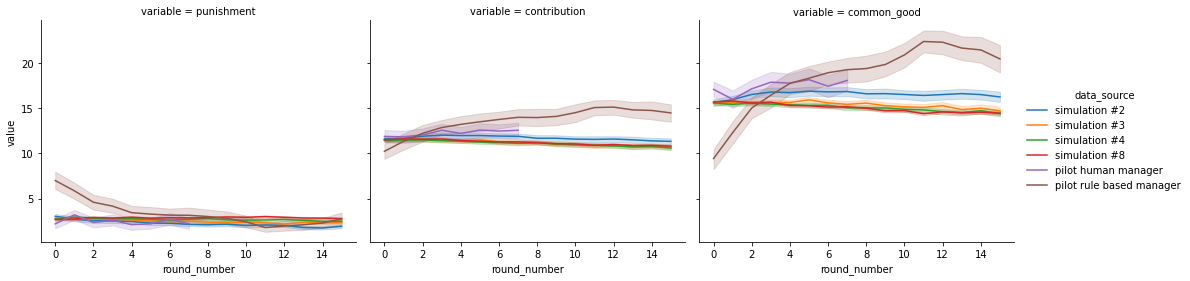

In [10]:
g = sns.relplot(
    data=dfm,
    x="round_number", 
    y="value",
    col='variable',
    hue='data_source',
    kind="line",
    height=4, aspect=1.2,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot.jpg'))

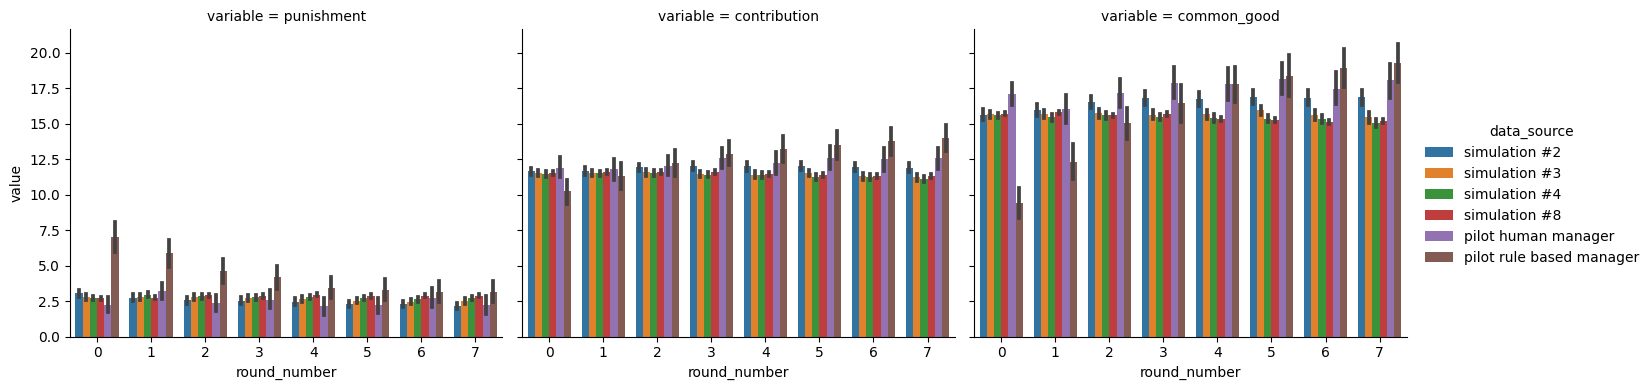

In [13]:
w = (
    (dfm['round_number'] <= 7)
    # (dfm['data_source'].isin(['simulation #4', 'simulation #8', 'pilot human manager']))
)


g = sns.catplot(
    data=dfm[w],
    x="round_number", 
    y="value",
    col='variable',
    hue='data_source',
    kind="bar",
    height=4, aspect=1.2,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot_bar.jpg'))

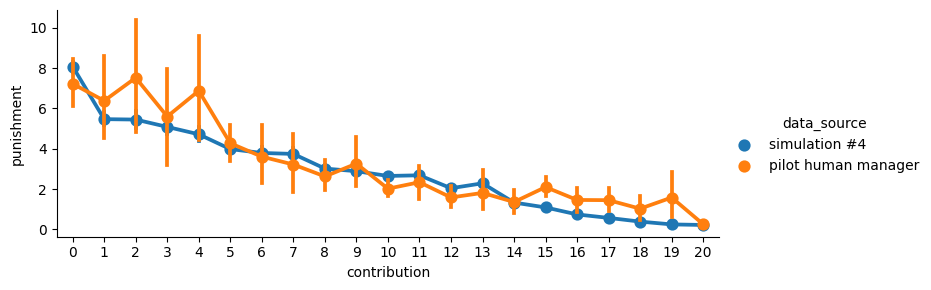

In [12]:
df['contribution'] = df['contribution'].astype(int)
g = sns.catplot(
    data=df[df['data_source'].isin(['simulation #4', 'pilot human manager'])],
    x="contribution", 
    y="punishment",
    hue='data_source',
    kind="point",
    height=3, aspect=2.5,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot_policy.jpg'))